# EE5934 Deep Learning Project 1

In this project, you are going to explore Deep Learning and Neural Networks by completing the following three tasks:

* Task 1. Network Exploration (30%)
* Task 2. Model Interpretation (30%)
* Task 3. Adversarial Attack (40%)

Before doing the project, please read the instructions carefully (failure to do so will be penalized):

1. Implement your codes **within** "TODO" and "END OF YOUR CODE", do **NOT** modify any codes outside the answer area;
2. Make sure your codes **clean**, **easily readable** (add meaningful comments if needed), and **runnable**;
3. Write your answers in the given markdown cells, keep your answers clear and concise;
4. Do submit your project to "Files/Project 1/Submissions" on [LumiNUS](https://luminus.nus.edu.sg/) before the deadline: **5:59 pm (SGT), 6 March, 2022**;
5. This is an individual project, do **NOT** share your solutions with others, we have zero tolerance for cheating.

If you have any questions regarding this project, please feel free to contact Wu Zhangjie (zhangjiewu@u.nus.edu). 

## Preparation

### Loading packages

Please install the packages listed below if you haven't done so. To avoid unnecessary trouble while reproducing your code, please install the required [PyTorch](https://pytorch.org/) version.

In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.cm as mpl_color_map
from PIL import Image
from random import randint

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
assert torch.__version__ == '1.9.0', 'Please reinstall pytorch to 1.9.0.'
assert torchvision.__version__ == '0.10.0', 'Please reinstall torchvision to 0.10.0.'

### Checking the Running Device

It is recommended to run this notebook on GPUs since that would be a much faster way to train and evaluate the model. If you have difficulties accessing GPUs with your machine, you can choose to use the free GPUs provided by [Google Colab](https://colab.research.google.com/).

In [2]:
if torch.cuda.is_available():
  device = 'cuda:0'
else:
  device = 'cpu'
print(device)

cuda:0


### Getting the CIFAR-10 Dataset

In [3]:
CIFAR_CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
CIFAR_MEAN, CIFAR_STD = np.array([0.4914, 0.4822, 0.4465]), np.array([0.247, 0.243, 0.261])

# Convert image to pytroch tensor and normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=CIFAR_MEAN.tolist(), std=CIFAR_STD.tolist())
])

# Inverse operation to regain original image
inverse_transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Normalize(mean=[0, 0, 0], std=(1 / CIFAR_STD).tolist()),
    torchvision.transforms.Normalize(mean=(-CIFAR_MEAN).tolist(), std=[1, 1, 1]),
    torchvision.transforms.ToPILImage()
])

# Load dataset
train_set = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
train_size = len(train_set)
test_set = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=transform)
test_size = len(test_set)

Files already downloaded and verified
Files already downloaded and verified


### Helper Fuctions

In [4]:
def show_prob_cifar(image, label, p):
    """
        Show image and prediction probability for CIFAR-10 dataset.
    Args:
    Inputs
        image (Tensor): Input image
        label (int): The ground truth label of input image
        p (Tensor): Class probability of input image
    
    """

    ft = 10
    width = 0.9
    col = 'blue'

    p=p.cpu().data.squeeze().numpy()
    y_pos = np.arange(len(p))
    fig = plt.figure(figsize=(5, 5))

    # Plot image
    ax1 = plt.subplot(2, 1, 1)
    ax1.imshow(image)
    ax1.set_axis_off()
    ax1.set_title('Ground Truth: ' + CIFAR_CLASSES[label])

    # Plot probability
    ax2 = plt.subplot(2, 1, 2)
    ax2.barh(y_pos, p*0.1, width , align='center', color=col)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(CIFAR_CLASSES, fontsize=ft)
    ax2.invert_yaxis()  
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_linewidth(4)
    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax2.text(p[i]*0.1 + 0.001, y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax2.transData, color= col,fontsize=ft)

    plt.show()


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on iamge
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

## Task 1: Network Exploration

In this task, you are expected to build a convolutional neural network (CNN) for solving a problem of image recognition and explore strategies that could further strengthen its performance.  

### Defining the Model

In deep learning, a Convolutional Neural Network (CNN, or ConvNet) is one of the most famous deep learning models that have been widely used in the field of computer vision. A simple CNN often consists of three main types of layers:
- **Convolutional Layer**, the core building block that takes over the most of computational burdens, contains a set of filters (or kernels) with learnable parameters while training. It receives as input an image (or a feature map), and computes its output volume by stacking the activation maps convolved by every filter along the depth dimension. 
- **Pooling Layer** is commonly inserted in-between successive Conv layers in a CNN architecture. Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network, and hence to also control overfitting. 
- **Fully Connected Layer** have fully connections to all activations in the previous layer and is usually placed before the output layer to form the last few layers of a CNN Architecture.

If you are not familiar with CNN architectures, [this blog](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) may help you get a better understanding of the mechanism of each layer.

Define a naive CNN stacked by the layers mentioned above. While doing so, please follow the TODOs provided below. (Refer to [torch.nn](https://pytorch.org/docs/stable/nn.html) for detailed instructions of building basic blocks with PyTorch.)

In [5]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        ##############################################################################
        # TODO: Define a simple CNN contraining Conv, Pooling, and FC layers.        #
        ##############################################################################
        self.model1 = nn.Sequential(
        # Block 1:         3 x 32 x 32 --> 64 x 16 x 16        
            nn.Conv2d(3, 64, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        # Block 2:         64 x 16 x 16 --> 128 x 8 x 8
            nn.Conv2d(64, 128, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        # Block 3:         128 x 8 x 8 --> 256 x 4 x 4        
            nn.Conv2d(128, 256, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),        
        # Block 4:          256 x 4 x 4 --> 512 x 2 x 2
            nn.Conv2d(256, 512, 3, 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 
        # Linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10
            nn.Flatten(),
            nn.Linear(2048, 4096),
            nn.Linear(4096, 10)
        )
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

    def forward(self, x):
        
        ##############################################################################
        # TODO: Implement forward path turning an input image to class probability.  #
        # For activation function, please use ReLU.                                  #
        ##############################################################################
        x = self.model1(x)
        # Block 1:         3 x 32 x 32 --> 64 x 16 x 16
        # Relu are included in the model initialization
        # Block 2:         64 x 16 x 16 --> 128 x 8 x 8

        # Block 3:         128 x 8 x 8 --> 256 x 4 x 4

        # Block 4:         256 x 4 x 4 --> 512 x 2 x 2

        # Linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 10

        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        
        return x

model = ConvNet()
model.to(device)
print(model)

ConvNet(
  (model1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2048, out_features=4096, bias=True)
    (14): Linear(in_features=4096, out_features=10, bias=True)
  )
)


### Training the Model

Some default settings for training. 

In [6]:
# Hyperparameters
epochs = 20
batch_size = 128
learning_rate = 0.25

# Set up optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Define loss function
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
# Build data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1)
data_loaders = {"train": train_loader, "test": test_loader}
dataset_sizes = {"train": train_size, "test": test_size}

Here, your job is to implement two functions for training and testing model.

In [18]:
def eval_on_test_set(model):
    model.eval()
    running_error = 0
#     correct = 0
    total = 0
    total_error = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
    #         pass

            ##############################################################################
            # TODO: Implement the evaluation process on test set.                        #
            ##############################################################################

            # Load inputs and labels and deploy to running device
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # Forward batch data through the net
            outputs = model(images)
            # Compute the error made on this batch and add it to the running error
            _, predicted = torch.max(outputs.data, 1)
            # the class with the highest energy is what we choose as prediction
            total += labels.size(0)
            running_error += (predicted != labels).sum().item()
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################

        total_error = running_error / test_size
        print('error rate on test set = {:.2f}%'.format(total_error * 100))
#         print(f'Accuracy of the network on the 10000 test images: {1- (100 * running_error // total)} %')
        model.train()
    return total_error

In [8]:
def train_net(model):
    start=time.time()
    model.train()

    for epoch in range(epochs):
        # set the running quatities to zero at the beginning of the epoch
        running_loss = 0.0
        running_error = 0
    
        for data in train_loader:
            ##############################################################################
            # TODO: Implement the training process.                                      #
            ##############################################################################

            # Load inputs and labels and deploy to running device
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Set the gradients to zeros
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()
            running_loss += loss.item()
#             if i % 2000 == 1999:    # print every 2000 mini-batches
#                 print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#                 running_loss = 0.0
                
            # Compute the error made on this batch and add it to the running error
            error_ = (outputs.argmax(1) != labels).sum()
            running_error = running_error + error_
            ##############################################################################
            #                             END OF YOUR CODE                               #
            ##############################################################################
            
        # Compute stats for the full training set
        total_loss = running_loss / train_size
        total_error = running_error / train_size
        elapsed = (time.time()-start) / 60
        
        print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t error= {:.2f}%'.format(epoch, elapsed, total_loss, total_error * 100))
        eval_on_test_set(model) 

Run `train_net` and start training. After training, your error on the testing set should be under 30% (if not, please look back and check your codes, there might be something wrong with the network architecture or training process). Once the training phrase is completed, save the trained model on your device so it can be directly loaded in the following tasks.

In [19]:
# Start training
train_net(model)

epoch= 0 	 time= 0.52 min 	 loss= 0.014 	 error= 65.85%
error rate on test set = 52.80%
epoch= 1 	 time= 1.10 min 	 loss= 0.009 	 error= 43.31%
error rate on test set = 43.02%
epoch= 2 	 time= 1.69 min 	 loss= 0.007 	 error= 32.25%
error rate on test set = 35.58%
epoch= 3 	 time= 2.27 min 	 loss= 0.006 	 error= 25.43%
error rate on test set = 33.38%
epoch= 4 	 time= 2.86 min 	 loss= 0.004 	 error= 19.83%
error rate on test set = 28.74%
epoch= 5 	 time= 3.45 min 	 loss= 0.003 	 error= 15.04%
error rate on test set = 28.12%
epoch= 6 	 time= 4.04 min 	 loss= 0.003 	 error= 11.90%
error rate on test set = 27.16%
epoch= 7 	 time= 4.64 min 	 loss= 0.002 	 error= 9.40%
error rate on test set = 25.88%
epoch= 8 	 time= 5.25 min 	 loss= 0.002 	 error= 7.45%
error rate on test set = 25.85%
epoch= 9 	 time= 5.87 min 	 loss= 0.001 	 error= 5.98%
error rate on test set = 27.60%
epoch= 10 	 time= 6.49 min 	 loss= 0.001 	 error= 5.36%
error rate on test set = 28.44%
epoch= 11 	 time= 7.13 min 	 loss= 

In [24]:
# Save the trained model
torch.save(model.state_dict(), './model_cnn.pt')

### Ploting the Results

Now you have finished model training, let's randomly pick some test images, feed them into your model and see how they turn out. (There is nothing to implement in this section.)

In [25]:
assert os.path.exists('./model_cnn.pt'), 'train the model first'
# Load the trained model
model.load_state_dict(torch.load('./model_cnn.pt', map_location=torch.device('cpu')))
model.to(device)
model.eval()

ConvNet(
  (model1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=2048, out_features=4096, bias=True)
    (14): Linear(in_features=4096, out_features=10, bias=True)
  )
)

5870


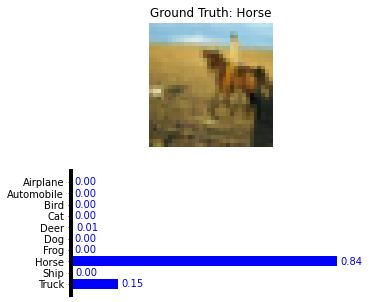

In [23]:
# Choose a picture at random
idx = randint(0, test_size-1)
print(idx)
im, label = test_set[idx]
org_im = inverse_transform(im)

# Send to device, rescale, and view as a batch of 1 
im = im.to(device)
im = im.view(1,3,32,32)

# Feed it to the net and display the confidence scores
scores = model(im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(org_im, label, probs)

### Refining the Model

Although the vallina model has achieved fair classification results, the test error is still high remaining huge room for further improvement. There are lots of methods to refine your model, such as **modifying the network architecture** (e.g., making your network deeper), **optimizing the learning strategy** (e.g., optimizer, loss function), and **tuning the hyperparameters** (e.g., learning rate, training iterations), etc. Please try at least **TWO** different methods to improve your model's performance, and discuss why these changes can work. Design and conduct your own experiments using the coding cell below, and present your experimental results and analysis in a decent way (e.g., drawing some neat figures/tables can help to convey your thoughts effectively). 

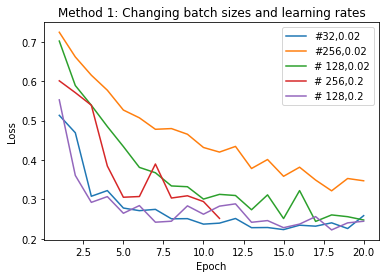

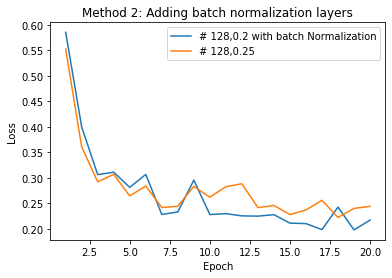

In [43]:
##############################################################################
# TODO: Conduct experiments to refine your model (e.g., modify the backbone, #
# alter the learning strategy, and tuning the hyperparameters, etc.).        #
##############################################################################

def refine_train_net(model, batch_size= 128, learning_rate = 0.2):
    epochs = 20
    batch_size = batch_size
    learning_rate = learning_rate
    # Set up optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    # Define loss function
    criterion = torch.nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)
    data_loaders = {"train": train_loader, "test": test_loader}
    dataset_sizes = {"train": train_size, "test": test_size}
    start=time.time()
    model.train()
    test_error = []
    for epoch in range(epochs):
        # set the running quatities to zero at the beginning of the epoch
        running_loss = 0.0
        running_error = 0
    
        for data in train_loader:
            pass
            ##############################################################################
            # TODO: Implement the training process.                                      #
            ##############################################################################


            # Load inputs and labels and deploy to running device
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Set the gradients to zeros
            # zero the parameter gradients
            optimizer.zero_grad()
            # Forward the batch data through the net       
            # forward + backward + optimize
            outputs = model(inputs)

            # Compute the average of the losses of the data points in the minibatch
            loss = criterion(outputs, labels)

            # Backward pass to compute gradients
            loss.backward()

            # Do one step of stochastic gradient descent
            optimizer.step()
            # Add the loss of this batch to the running loss
            running_loss += loss.item()
#             if i % 2000 == 1999:    # print every 2000 mini-batches
#                 print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#                 running_loss = 0.0
                
            # Compute the error made on this batch and add it to the running error
            error_ = (outputs.argmax(1) != labels).sum()
            running_error = running_error + error_
            ##############################################################################
            ##############################################################################
            
        # Compute stats for the full training set
        total_loss = running_loss / train_size
        total_error = running_error / train_size
        elapsed = (time.time()-start) / 60
        
        print('epoch= {} \t time= {:.2f} min \t loss= {:.3f} \t error= {:.2f}%'.format(epoch, elapsed, total_loss, total_error * 100))
        test_error_i = eval_on_test_set(model)
#         print(test_error_i)
        test_error.append(test_error_i)
#         print(test_error)
    return test_error

# Method1: tuning batch sizes and learning rates when training the model

# Set batch size to 256 and learning rate to 0.2 and train the model1
model2c = ConvNet()
model2c.to(device)
model2c.eval()
test_error_B256LR02 = refine_train_net(model2c,256,0.2)
# print(test_error_B256LR02)

# Set batch size to 256 and learning rate to 0.02 and train the model1
model2b = ConvNet()
model2b.to(device)
model2b.eval()
test_error_B256LR002 = refine_train_net(model2b,256,0.02)
test_error_B256 = [0.5794, 0.4806, 0.4035, 0.3369, 0.3454, 0.2741, 0.324, 0.2533, 0.2557, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0, 0., 0.]
# print(test_error_B256LR002)

# Set batch size to 128 and learning rate to 0.2 and train the model
model = ConvNet()
model.to(device)
model.eval()
test_error_B128LR02 = refine_train_net(model,128,0.2)
# print(test_error_B128LR02)

# Set batch size to 32 and learning rate to 0.02 and train the model1
model2a = ConvNet()
model2a.to(device)
model2a.eval()
test_error_B32LR002 = refine_train_net(model2a,32,0.02)
# print(test_error_B32LR002)

# Set batch size to 128 and learning rate to 0.02 and train the model1
model2 = ConvNet()
model2.to(device)
model2.eval()
test_error_LR002 = refine_train_net(model2,128,0.02)
# print(test_error_LR002)

##Figure 1: plot loss of the model with different batch sizes and learning rates after each epoch
import matplotlib.pyplot as plt

n_epochs =list(range(1,21))
plt.plot(n_epochs, test_error_B32LR002, label = '#32,0.02')
plt.plot(n_epochs, test_error_B256LR002, label = '#256,0.02')
plt.plot(n_epochs, test_error_LR002,label = '# 128,0.02')
plt.plot(n_epochs[:11], test_error_B256LR02[:11], label = '# 256,0.2')
plt.plot(n_epochs, test_error_B128LR02, label = '# 128,0.2')
plt.title("Method 1: Changing batch sizes and learning rates")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

##Method 2: add batch normalization and dropout layer and compare with the original model 
class ConvNet3(nn.Module):
    def __init__(self):
        super(ConvNet3, self).__init__()
        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(3,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
# 
            nn.Flatten(),
            nn.Linear(2048, 4096),
            nn.Dropout(p=0.2),
            nn.Linear(4096, 1024),
#             nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # fc layer
        x = self.fc_layer(x)
        return x

model3 = ConvNet3()
model3.to(device)
test_error_BNDO = refine_train_net(model3,128,0.25)
test_error_BNDO

#Figure 2: Plot the performance of model with batch normalization vs the original model 
n_epochs =list(range(1,21))
plt.plot(n_epochs, test_error_BNDO, label = '# 128,0.2 with batch Normalization')
plt.plot(n_epochs, test_error_B128LR02, label = '# 128,0.25')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Method 2: Adding batch normalization layers")
plt.legend()
plt.show()

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

---

**Write your observations and analysis in this Markdown cell:**

---
#### Method1: tuning batch sizes and learning rates when training the model

    In the first chart, the yellow (batch size: 256 & learning rate: 0.02), green (batch size: 128 & learning rate: 0.02) and blue lines (batch size: 256 & learning rate: 0.02) represent training with same the same learning rate.  From the chart we can observe that smaller batch size tend to have better performance with 20 epochs. It may be because larger batch size means fewer iterations in each epoch, therefore the neural network is underfitting the dataset.

    From the green and purple lines, we can observe that at beginning large learning rate leads to a smaller loss quickly, but at the end green line (small LR) catch up and overtake purple line. It shows that large learning rates are fast to train the model at the beginning, but may not reach a global optimum finally. Small learning rate achieves a better test accuracy when enough training epochs are provided. 

    Therefore, better hyperparameters to train this network should have a relatively small batch size and small learning rate. That is batch size = 32 and learning rate = 0.02 in this experiment. 



#### Method2: add batch normalization and dropout layers and compare with the original model 

    From the second chart, the model with the Batch Normalization and dropout layers (blue line) perform better than the original model (yellow line) after 10 epochs. Batch Normalization and dropout layer do improve the final test accuracy (at 20th epoch) by 5%, because they can fix internal covariate shift and prevent model overfitting to the training data.


## Task 2: Model Interpretation

The model is doing well, eating images and predicting results; however, everything that happens inside is opaque and hard to explain. So, how can we interpret how CNN sees and understands when making a decision? 

In this section, we are going to explore Grad-CAM, a visual explanation algorithm that generates heatmaps indicating where the network is "looking" in the forward pass.

#### Grad-CAM

Gradient-weighted Class Activation Mapping (Grad-CAM) [1], uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept. An overview of the workflow of Grad-CAM is shown below. Please read the paper [1], understand the algorithm, and implement `generate_cam`.

<img src="./figures/gradcam_network.png" width="800"/>

[1] [Selvaraju, Ramprasaath R., et al. "Grad-cam: Visual explanations from deep networks via gradient-based localization." ICCV 2017.](https://arxiv.org/abs/1610.02391)

In [52]:
gradients = []  # A gloabl variable used to save the gradient
def generate_cam(model, input_image, target_layer= 9, target_class=None):
    """
    A function to generate Grad-CAM of specific layer and class on an input image using given model.
  
    Inputs
    - model: A PyTorch model.
    - input_image: A PyTorch Tensor of shape (1, C, H, W).
    - target_layer: A String indicating the name of targeted convolutional layer being visualized (e.g., 'conv4').
                    By default, use the last conv layer of the model.
    - target_class: An Integer indicating the lable of targeted class being visualized (e.g., 1). 
                    If None, use the predicted class as target class.
    
    Returns: A NumPy Array of shape (N, C, H, W) showing the intended heatmap.
    """

    ##############################################################################
    # TODO: Given an input image, generate its Grad-CAM on target conv layer     #
    # using the backward gradients from a specific class.                        #
    # 1. Forward the input image, when you also need to register the gradient    #
    # hook so as to get the gradient in backward pass (hint: register_hook).     #
    # 2. Backward pass with specified target class, and get gradients.           #
    # 3. Average each gradient, multiply with its conv output, and sum together. #
    ##############################################################################
    
    fmap_block = list()
    grad_block = list()

    def backward_hook(module, grad_in, grad_out):
        grad_block.append(grad_out[0].detach())


    def farward_hook(module, input, output):
        fmap_block.append(output)
        
    
    net=model.to(device)
    bw_hook = net.model1[target_layer].register_forward_hook(farward_hook)
    fw_hook = net.model1[target_layer].register_backward_hook(backward_hook)
    
    
    print("Target Layers targetting is: {}".format(model.model1[target_layer]))
    #forward
#     model.eval()
#     outputs = model(input_image)
    im = input_image
    net.eval()
    output = net(im)

    
    if target_class == None:
        
        idx = np.argmax(output.cpu().data.numpy())
        
        target_class = torch.tensor(idx).unsqueeze(0)
        target_class = target_class.to(device)
        print("predict: {}".format(CIFAR_CLASSES[idx]))
    
    def comp_class_vec(ouput_vec, index=None):
        if not index:
            index = np.argmax(ouput_vec.cpu().data.numpy())
        else:
            index = np.array(index)
        index = index[np.newaxis, np.newaxis]
        index = torch.from_numpy(index)
        one_hot = torch.zeros(1, 10).scatter_(1, index, 1).to(device)
        print(one_hot.get_device())
        one_hot.requires_grad = True
        class_vec = torch.sum(one_hot * output)  # one_hot = 11.8605

        return class_vec

#     loss = criterion(outputs,target_class)
#     loss.backward()
#     class_loss = comp_class_vec(output)

    
    net.zero_grad()
    class_loss = criterion(output,target_class)

    class_loss.backward()
    
    
    grads_val = grad_block[0].cpu().data.numpy().squeeze()
    fmap = fmap_block[0].cpu().data.numpy().squeeze()
    
    def gen_cam(feature_map, grads, input_image):
        """
        :param feature_map: np.array， in [C, H, W]
        :param grads: np.array， in [C, H, W]
        :return: np.array, [H, W]
        """
        cam = np.zeros(feature_map.shape[1:], dtype=np.float32)  # cam shape (H, W)

        weights = np.mean(grads, axis=(1, 2))  #

        for i, w in enumerate(weights):
            cam += w * feature_map[i, :, :]

        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                        input_image.shape[3]), Image.ANTIALIAS))

        return cam
    
    
    cam = gen_cam(fmap, grads_val, im)
    cam = np.maximum(cam, 0)
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
    cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
    cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                    input_image.shape[3]), Image.ANTIALIAS))
    
    bw_hook.remove()
    fw_hook.remove()
    return cam
    
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

Target Layers targetting is: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
predict: Bird


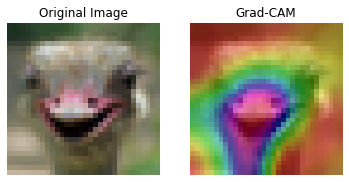

In [54]:
idx = randint(0, test_size-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

ax = plt.subplot(1, 2, 1)
ax.imshow(org_im)
ax.set_title('Original Image')
ax.set_axis_off()

cam = generate_cam(model, im, target_layer= 9)
heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')

ax = plt.subplot(1, 2, 2)
ax.imshow(heatmap_on_image)
ax.set_title('Grad-CAM')
ax.set_axis_off()

### Performing Visual Explanation

Now you have successfully built a powerful tool (i.e., Grad-CAM) that can assist you to visualize and understand the CNN models. Try to make full use of `generate_cam` and design at least **TWO** experiments that can further explain how CNN sees and understands the images. For example, apply Grad-CAM on different layers and compare their differences. Please quantitatively show some evidence (e.g., plotting some examplar images clearly and elegantly) with necessary code snippets, write down your observations and briefly explain each. 

Results of Experiment 1
Image ID: 7532
Predicted class is: Automobile
Target Layers targetting is: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Target Layers targetting is: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: ReLU()
Target Layers targetting is: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: ReLU()
Image ID: 6291
Predicted class is: Truck
Target Layers targetting is: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Target Layers targetting is: Conv2d

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in true_divide


Predicted class is: Airplane
Target Layers targetting is: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Target Layers targetting is: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: ReLU()
Target Layers targetting is: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: ReLU()
Image ID: 1848
Predicted class is: Cat
Target Layers targetting is: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Target Layers targetting is: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1

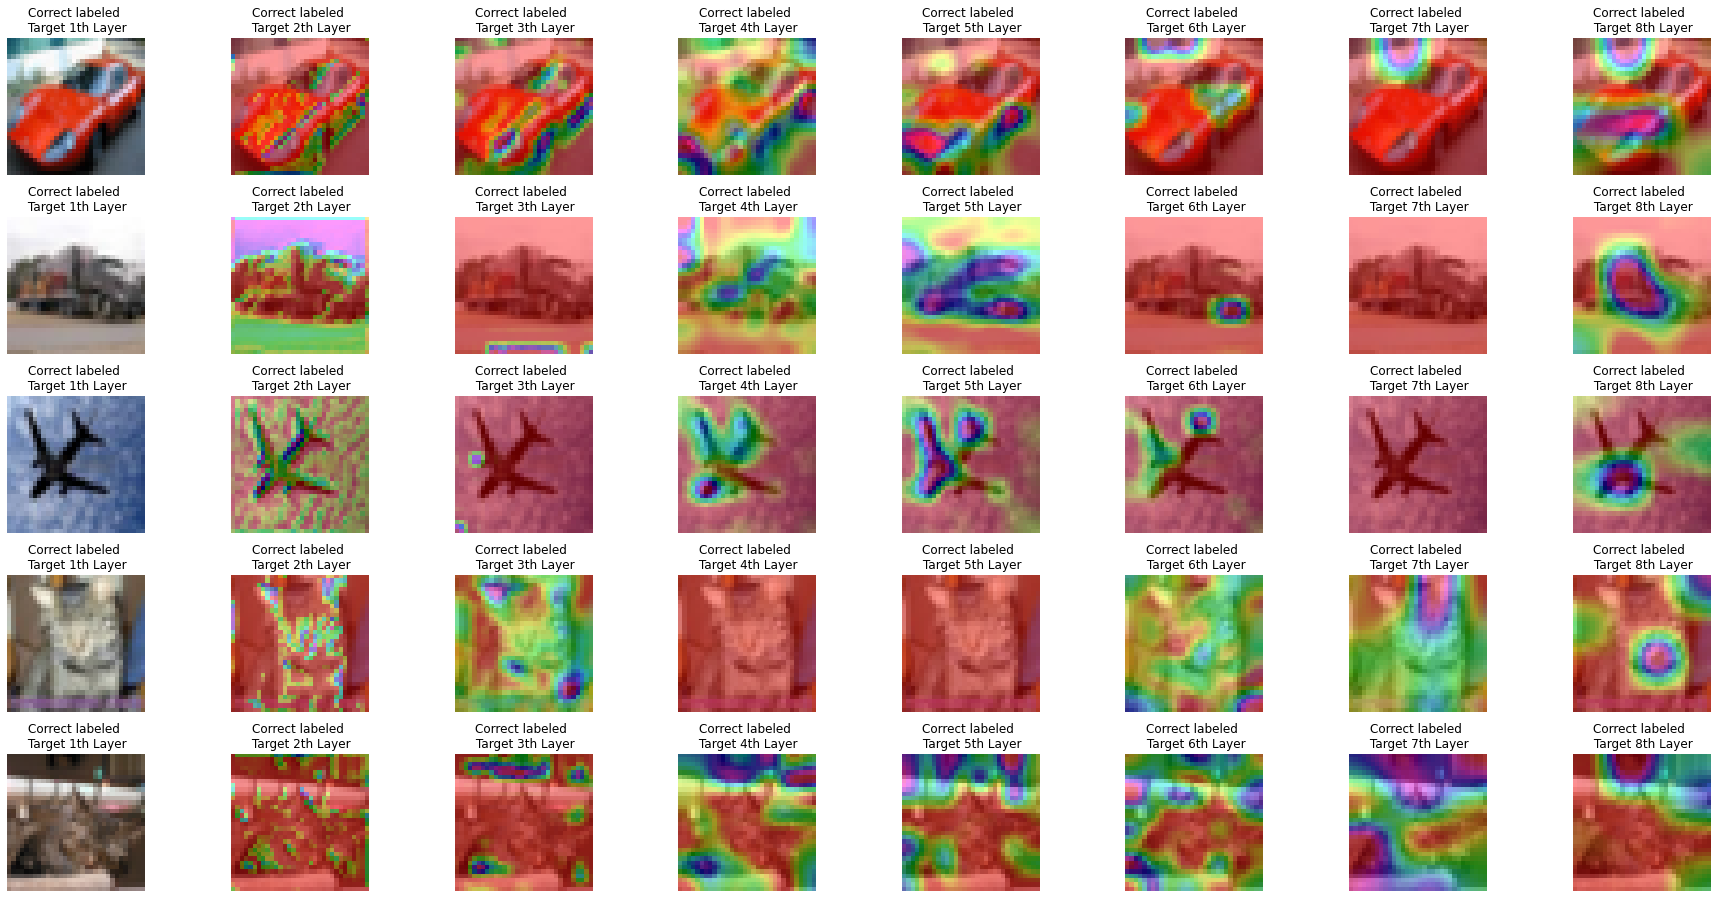

Results of Experiment 2
Image ID: 7532
Predicted class is: Automobile
Target Layers targetting is: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Target Layers targetting is: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: ReLU()
Target Layers targetting is: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: ReLU()
Image ID: 6291
Predicted class is: Cat
Target Layers targetting is: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Target Layers targetting is: Conv2d(1

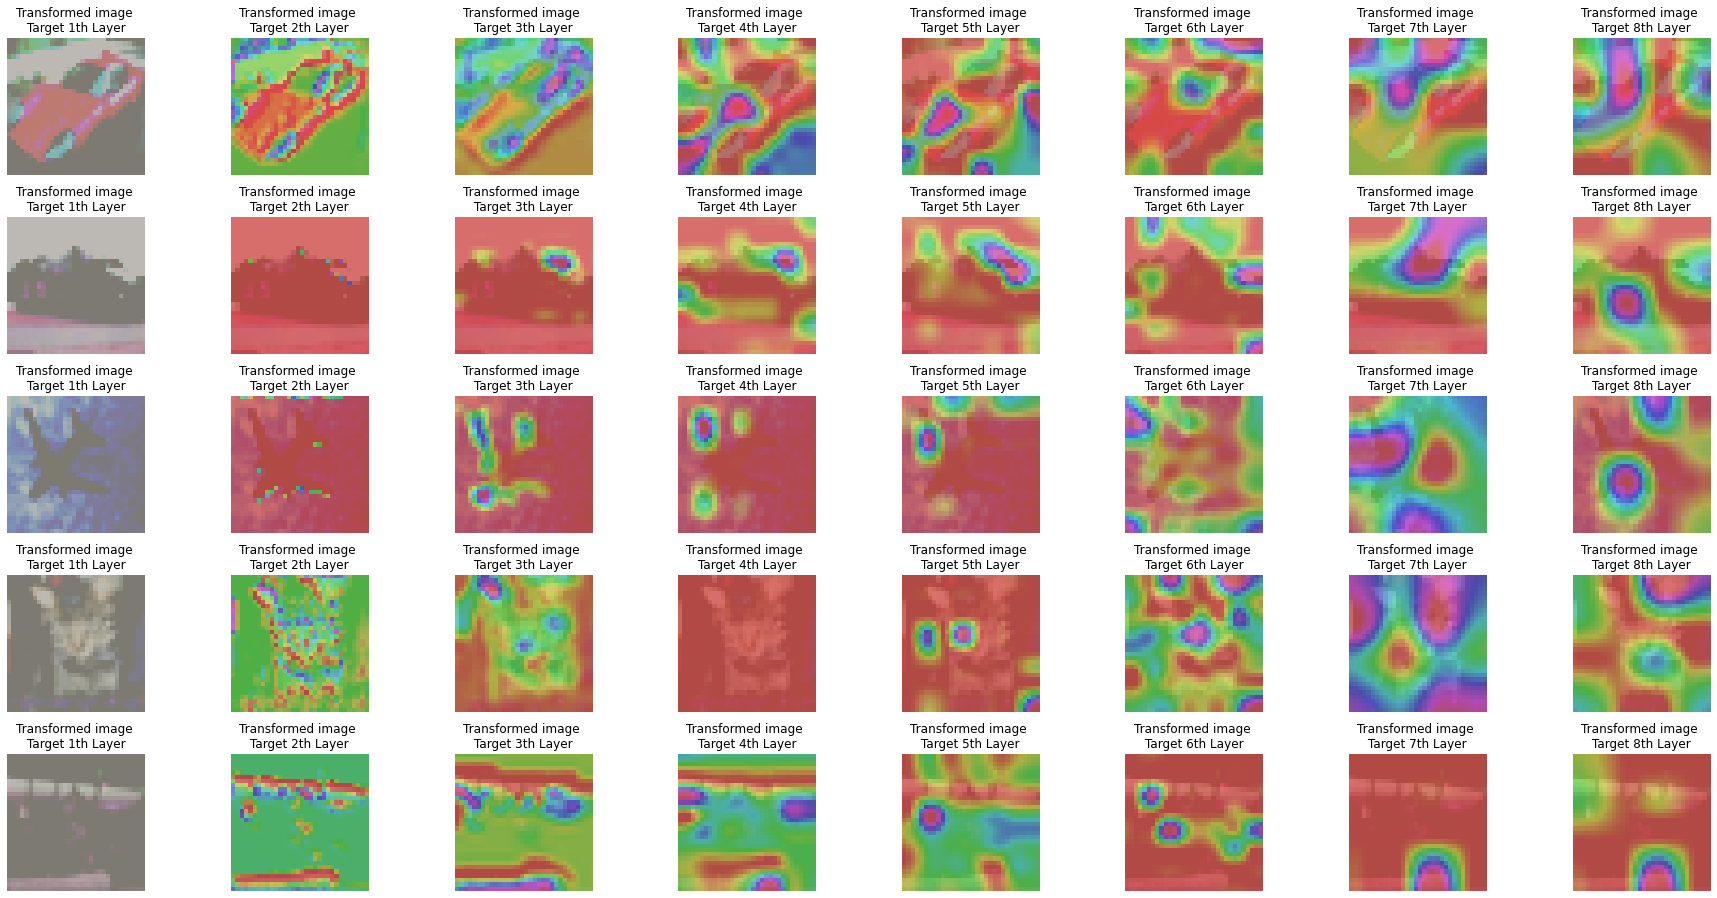

Results of Experiment 3
Image ID: 8653
Predicted class is: Automobile
Target Layers targetting is: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Target Layers targetting is: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: ReLU()
Target Layers targetting is: Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: ReLU()
Image ID: 5714
Predicted class is: Cat
Target Layers targetting is: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Target Layers targetting is: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Target Layers targetting is: Conv2d(1

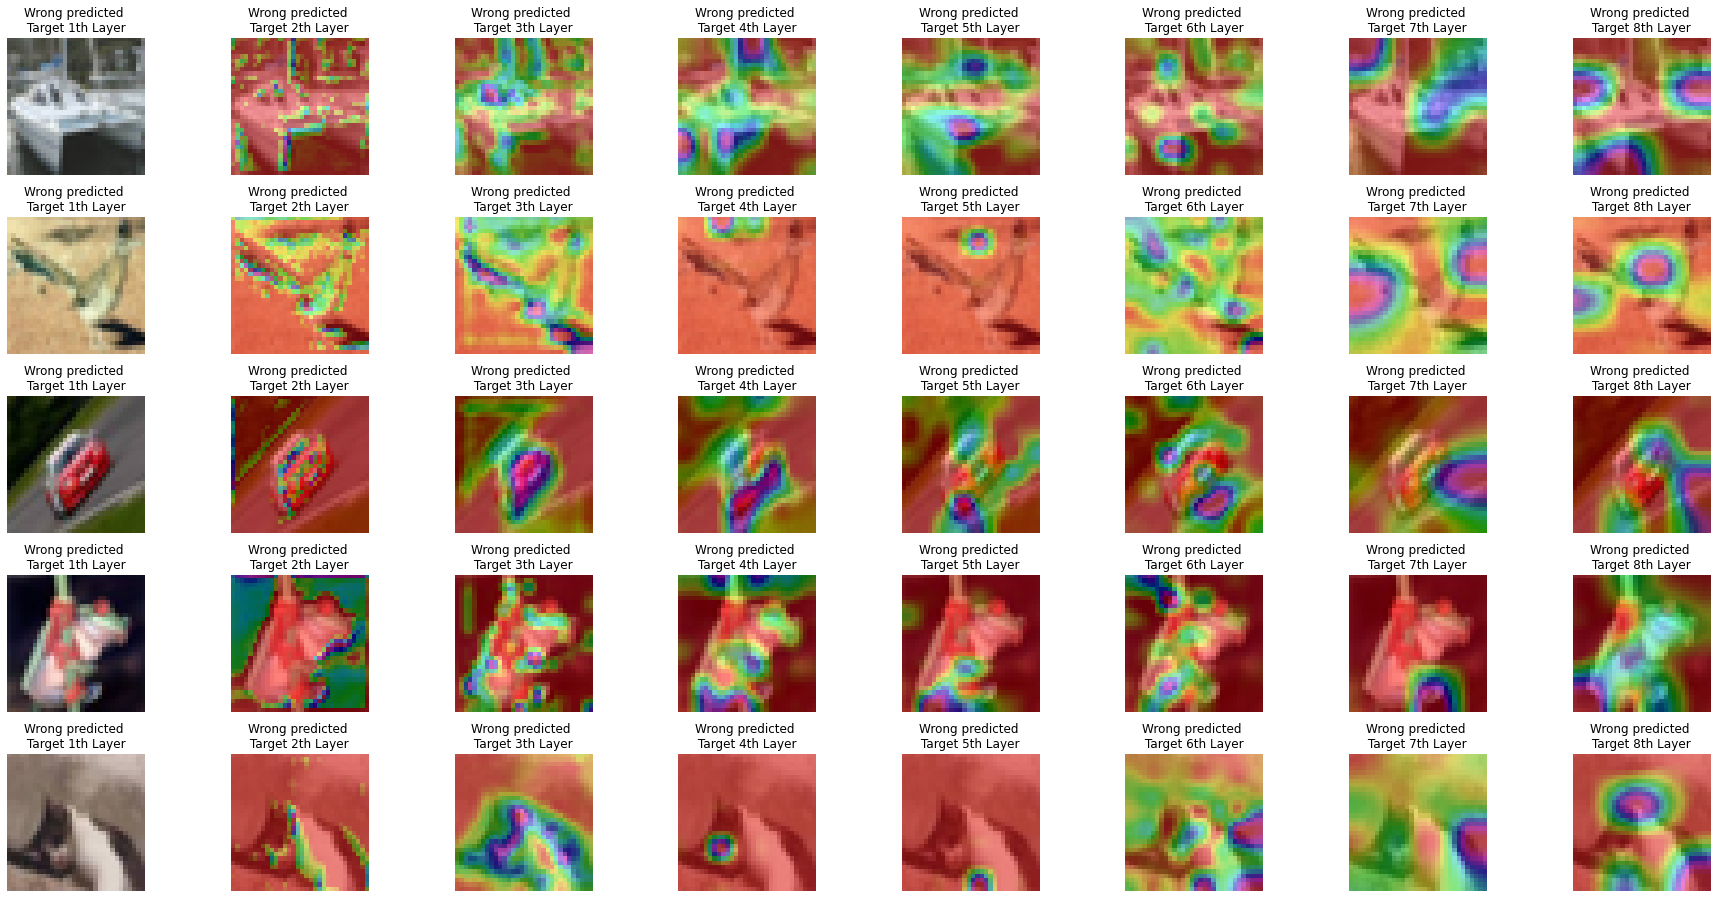

In [26]:
##############################################################################
# TODO: Write code snippets to present your experiments (hint: if you want   #
# to plot multiple images in one single figure, plt.subplot should help).    #
##############################################################################
# Experiment1: apply Grad-CAM to convolutional layer layers and ReLu layer of the network and compare the result. 

def generate_predict(im, model):
    scores = model(im)
    predict = np.argmax(scores.cpu().data.numpy())
    print('Predicted class is: {}'.format(CIFAR_CLASSES[predict]))
    return CIFAR_CLASSES[predict]

def differnt_layer(idx,model, layer_list = [9], transform = False):
    print('Image ID: {}'.format(idx))
    im, label = test_set[idx]
    if transform == False:
        org_im = inverse_transform(im)
        im = im.view(1,3,32,32)
        im = im.to(device)
    
    else: 
#         gray_img = T.RandomRotation(degrees=(0,90))(im)
        gray_img = torchvision.transforms.ColorJitter(brightness=.5, hue=.2)(im)
#         # plot([gray_img], cmap='gray')
#         gray_img.size()
#         # im.size()
        im = gray_img.view(1,3,32,32)
        im = im.to(device)
        org_im = inverse_transform(gray_img)
    
    generate_predict(im, model)
    layer_list = layer_list
    heatmap_list = []
    heatmap_on_image_list= [org_im]
    for i in layer_list: 
            cam = generate_cam(model, im, target_layer=i)
            heatmap, heatmap_on_image = apply_colormap_on_image(org_im, cam, 'hsv')
            heatmap_list.append(heatmap)
            heatmap_on_image_list.append(heatmap_on_image)
    return heatmap_list, heatmap_on_image_list

wrong_list = [8653, 5714, 6010, 6543, 1782, 4615, 1724, 8928, 332, 9437, 1552, 1042, 6378, 652, 8349, 6642, 6163, 3219, 6783, 3812, 6597]
correct_list = [7532, 6291, 2674, 1848, 8102, 6209, 8228, 2031, 4674, 4263, 7303, 7460, 4895, 9290, 6949, 5935, 7422, 2254, 8709]
fig = plt.figure(figsize=(25,25))
a = 0
traget_layers = [0,3,5,6,7,9,10]

def plot_heatmaps(heatmap_on_image_list, a, title = 'Correct labeled \n Target {}th Layer'): 
    row = 10
    col = len(traget_layers)+1
    for i in range(1, len(heatmap_on_image_list)+1):
        ax = fig.add_subplot(row,col,i+a)
#         print(i)
        ax.imshow(heatmap_on_image_list[i-1])
        ax.set_title(title.format(i))
        ax.set_axis_off()
    a = a+ i
    return a

# Experiment1: apply Grad-CAM to convolutional layer layers and ReLu layer of the network and compare the result. 
print('Results of Experiment 1')

for idx in correct_list[:5]: 
    heatmap_list, heatmap_on_image_list = differnt_layer(idx, model, traget_layers)
    a = plot_heatmaps(heatmap_on_image_list,a, 'Correct labeled \n Target {}th Layer')
    
fig.tight_layout()
plt.show()

# Experiment2: Transform the color of the original correct images and apply Grad-CAM to different layers of the model
print('Results of Experiment 2')
fig = plt.figure(figsize=(25,25))
a = 0
traget_layers = [0,3,5,6,7,9,10]

for idx in correct_list[:5]:   #[5:15]: 
    heatmap_list, heatmap_on_image_list = differnt_layer(idx, model, traget_layers, transform = True)
    a = plot_heatmaps(heatmap_on_image_list,a, 'Transformed image \n Target {}th Layer ')
fig.tight_layout()
plt.show()

# Experiment3: Apply Grad-CAM to different layers of the network and check why the model predicts the wrong lable.
print('Results of Experiment 3')
fig = plt.figure(figsize=(25,25))
a = 0
traget_layers = [0,3,5,6,7,9,10]

# heatmap_list = []
# heatmap_on_image_list =[]
for idx in wrong_list[:5]: 
    heatmap_list, heatmap_on_image_list = differnt_layer(idx, model, traget_layers)
    a = plot_heatmaps(heatmap_on_image_list,a, 'Wrong predicted \n Target {}th Layer ')
    
fig.tight_layout()
plt.show()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

---

**Write your observations and analysis in this Markdown cell:**

#### Experiment1: apply Grad-CAM to convolutional layer layers and ReLu layer of the network and compare the result. 
    From the result we can see that the model can capture the outline of the object in the first or second convolutional 
    layers, and it is able to highlight the correct regions of interest at the last convolutional and Relu layer.

#### Experiment2: Transform the color of the original correct images and apply Grad-CAM to different layers of the model
    In experiment two, I changed the brightness and hue of the original images and feed them into the same network model.
    From the result we can see that the model can still capture the outline of the object in the first few convolutional 
    layers, but areas of interest highlighted by the last convolutional are different from those in experiment one. My
    hypothesis is changing of colour will affect gradient in the latest few layers more and then subsequently might influent 
    the model's prediction.
    
#### Experiment3: Apply Grad-CAM to different layers of the network andn check why the model predicts the wrong lable.
    In this experiment, we input some images that the network would predict wrongly and apply Grad-CAM to the model. 
    We can observe that the last few layers might hightlight the correct region but still output the wrong labels. This 
    could be because the highlighted features are very similar to features from another class. We can also observe that 
    sometimes model highlight the area outside the object. It may due to similarity of the object and its background, 
    such as the second bird picture.
    
---

## Task 3: Adversarial Attack

After going through some testing results in Task 1, you might think in most cases the model performs pretty well, predicting the correct classes with high confidence, and rarely making mistakes. However, the network is not as strong as you think. The network can be vulnerable and easily fooled by simply adding some very small distributions on input images. In this section, we are going to attack our previously trained model by generating adversarial images that visually look alike but crush the model without striking a blowing.

### Adversarial Examples

Adversarial examples are specialised inputs created with the purpose of confusing a neural network, resulting in the misclassification of a given input. These examples are usually generated by adding imperceptible non-random perturbations to the image, which are indistinguishable to human eye, but can cause the network to fail to identify the contents of the image. There are many kinds of such attack strategies, here we focus on the **Fast Gradient Sign Method (FGSM)** [2]. FGSM is a white box attack where the attacker has complete access to the model being attacked. The method uses the gradients of the loss with respect to the input image to create a new image that maximises the loss. Below shows a famous exmaple taken from the paper [2], where the classification of image showing "panda" is changed to "gibbon" after adding an imperceptibly small vector: $\text{sign}(\nabla_xJ(\theta, x, y))$.

<img src="./figures/adversarial_example.png" width="800"/>

Read the paper [2] for more details, and then implement the following function `generate_adv_image`, which generates "fooling images" of target class to attack your network. 

[2] [Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.](https://arxiv.org/abs/1412.6572)

In [61]:
def generate_adv_image(model, inputs, labels, targets=None, eps=0.07):
    """
    A function to generate adversarial examples.
  
    Inputs
    - model: A PyTorch model.
    - inputs: Input images, a PyTorch Tensor of shape (N, C, H, W).
    - labels: Ground truth labels of input images, a PyTorch Tensor of shape (N,).
    - targets: The target classes you want the model to misclassify, a PyTorch Tensor of shape (N,).
    
    Returns: The adversarial examples of given images.
    """


    ##############################################################################
    # TODO: Implement Fast Gradient Sign Method to generate an adversarial image #
    # that fools the model to predict incorrect class.                           #   
    # 1. Get the gradients of the loss w.r.t to the input image.                 #
    # 2. Get the sign of the gradients to create the perturbation.               #
    # 3. Add the perturbation to the input image.                                #
    ##############################################################################
    
    model = model.to(device)

    model.eval()

#         for data, target in test_loader:
    inputs = inputs.to(device)
    labels = torch.tensor(labels).unsqueeze(0)
    labels = labels.to(device)
#         data, target = data.to(device), target.to(device)

    inputs.requires_grad = True

    output = model(inputs)

#         init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
#         if init_pred.item() != target.item():
#             continue
    loss = F.nll_loss(output, labels)

    model.zero_grad()

    loss.backward()

    data_grad = inputs.grad.data


    adv_inputs = None

    def fgsm_attack(image, epsilon, data_grad):
        sign_data_grad = data_grad.sign()
        perturbed_image = image + epsilon*sign_data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        return perturbed_image
#         adv_inputs=fgsm_attack(model, inputs, labels, targets, eps)

    adv_inputs= fgsm_attack(inputs, eps, data_grad)

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################

    return adv_inputs.detach()

### Attacking the Model

Randomly pick up some images from test set, and attack the model using adversarial examples generated by `generate_adv_image`.

Before attack:


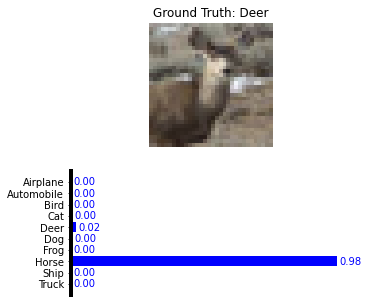

After attack:


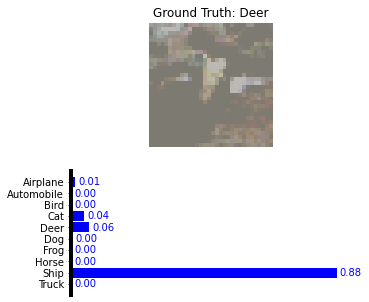

In [62]:
idx = randint(0, len(test_set)-1)
im, label = test_set[idx]
org_im = inverse_transform(im)

im = im.to(device)
im = im.view(1,3,32,32)

print('Before attack:')
scores = model(im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(org_im, label, probs)

adv_im = generate_adv_image(model, im, label)

print('After attack:')
scores = model(adv_im) 
probs = F.softmax(scores, dim=1)
show_prob_cifar(inverse_transform(adv_im[0]), label, probs)

Run evaluation on the testing set to see how the model performs on the generated adversarial examples, and compare with results before attacks. Try different parameters (e.g., `targets`, `eps`), describe your observations with a brief explanation in the below cell. 

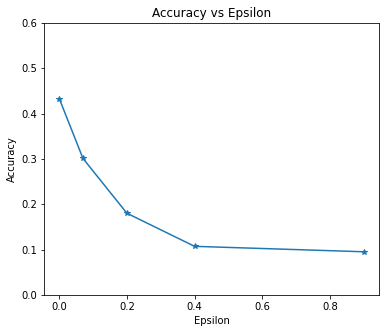

In [13]:
##############################################################################
# TODO: Evaluate error rate on adversarial images generated from testing set #
# with different parameter settings.                                         #
##############################################################################

def test( model, device, test_set, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    l= 1000      # Loop first 1000 examples in the test set
#     l = len(test_set)
#     for data, target in test_loader:
    for idx in range(l):
#      test_set
        im, label = test_set[idx]
        org_im = inverse_transform(im)

        im = im.to(device)
        im = im.view(1,3,32,32)

#         perturbed_data = fgsm_attack(data, epsilon, data_grad)
        perturbed_data = generate_adv_image(model, im, label,  targets=None, eps=epsilon)
        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == label:
            correct += 1
            adv_examples.append( (label, final_pred.item(), idx))

    final_acc = correct/float(l)

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples
 
    
accuracies = []
examples = []

epsilons = [0, 0.07, 0.2, 0.4, 0.9]
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_set, eps)
    accuracies.append(acc)
    examples.append(ex)

# print(accuracies)
# print(examples)
plt.figure(figsize=(6,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 0.7, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

---

**Write your observations and analysis in this Markdown cell:**
   
    The above chart shows the relationship between model prediction accuracy and perturbations term: epsilon. 
    As epsilon increase, the accuracy rate in the test set drops rapidly. It is because the original pictures' pixels
    deviate a larger value if epsilon is bigger, given the same gradient on that picture. However, there is trade
    off between epsilon and the identifiably of the Adversarial image. we should choose epsilon to be 0.4 in 
    this case as bigger epsilon such as 0.6 will have similar adversarial effect as epsilon equals to 0.4.

---